<a href="https://colab.research.google.com/github/rameenhamad/Developer_HUB_ML_Tasks/blob/main/3_2_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Dataset

In [2]:
dataset_dir = "/content/drive/MyDrive/Developer_HUB_ML_Tasks/Week 3/chest_xray"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

PreprocessData(ResizingImages + Splitting Data)

In [3]:
ImageSize = (128, 128)
BatchSize = 32

train_ds = utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode="binary",
    batch_size=BatchSize,
    image_size=ImageSize,
    validation_split=0.2,
    shuffle=True,
    seed=123,
    subset="training"
)

val_ds = utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode="binary",
    batch_size=BatchSize,
    image_size=ImageSize,
    validation_split=0.2,
    seed=123,
    subset="validation"
)

test_ds = utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode="binary",
    batch_size=BatchSize,
    image_size=ImageSize,
    shuffle=True,
    seed=123,
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
class_names = train_ds.class_names
print("classes: ", class_names)

classes:  ['NORMAL', 'PNEUMONIA']


Augmantation + Normalization

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))
test_ds = test_ds.map(lambda x, y: (x/255.0, y))

Plotting Random Samples from Dataset

Shape: (128, 128, 3)
Dtype: <dtype: 'float32'>
Min: 0.0
Max: 0.95091915


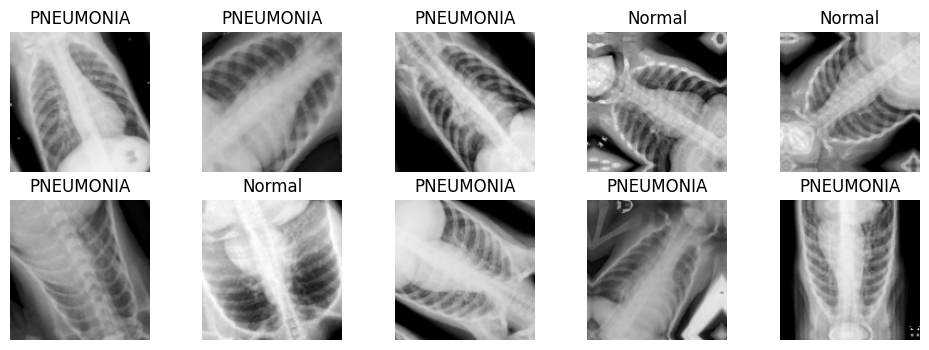

In [6]:
for images, labels in train_ds.take(1):
    print("Shape:", images[0].shape)
    print("Dtype:", images[0].dtype)
    print("Min:", tf.reduce_min(images[0]).numpy())
    print("Max:", tf.reduce_max(images[0]).numpy())

    plt.figure(figsize=(12,4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy())
        label = int(labels[i].numpy().squeeze())
        plt.title("PNEUMONIA" if label == 1 else "Normal")
        plt.axis("off")
    plt.show()

Autotune prefetch adta

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Building Model

In [8]:
model = models.Sequential([
    layers.Input(shape=(128,128,3)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer="adam", loss='binary_crossentropy', metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,121 (1.22 MB)

 Trainable params: 318,337 (1.21 MB)

 Non-trainable params: 784 (3.06 KB)

CallBack Functions

In [9]:
reduce_lr = ReduceLROnPlateau( monitor='val_loss', patience=3)
early_stop = EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)

callback = [early_stop, reduce_lr]

Moddel training

In [12]:
history = model.fit(train_ds, validation_data=val_ds, callbacks=callback, epochs=10, verbose=2)

Epoch 1/10
131/131 - 782s - 6s/step - accuracy: 0.8268 - loss: 0.4503 - val_accuracy: 0.7744 - val_loss: 0.5596 - learning_rate: 1.0000e-03
Epoch 2/10
131/131 - 766s - 6s/step - accuracy: 0.8340 - loss: 0.4088 - val_accuracy: 0.7744 - val_loss: 0.5610 - learning_rate: 1.0000e-03
Epoch 3/10
131/131 - 807s - 6s/step - accuracy: 0.8268 - loss: 0.4035 - val_accuracy: 0.6807 - val_loss: 0.5899 - learning_rate: 1.0000e-03
Epoch 4/10
131/131 - 812s - 6s/step - accuracy: 0.8368 - loss: 0.3763 - val_accuracy: 0.7992 - val_loss: 0.3940 - learning_rate: 1.0000e-03
Epoch 5/10
131/131 - 816s - 6s/step - accuracy: 0.8383 - loss: 0.3646 - val_accuracy: 0.8671 - val_loss: 0.2822 - learning_rate: 1.0000e-03
Epoch 6/10
131/131 - 776s - 6s/step - accuracy: 0.8502 - loss: 0.3515 - val_accuracy: 0.8834 - val_loss: 0.2985 - learning_rate: 1.0000e-03
Epoch 7/10
131/131 - 803s - 6s/step - accuracy: 0.8581 - loss: 0.3401 - val_accuracy: 0.3126 - val_loss: 2.1180 - learning_rate: 1.0000e-03
Epoch 8/10
131/131 -

Model Evaluating

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7335 - loss: 0.5606


Accuracy

In [15]:
train_loss, train_acc = model.evaluate(train_ds, verbose=1)
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
val_loss, val_acc = model.evaluate(val_ds, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7892 - loss: 0.4002
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7335 - loss: 0.5606
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8776 - loss: 0.2677


In [16]:
print("Accuracy,                        Loss")
print(f"Train Accuracy: {train_acc:.4f},          Train Loss: {train_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f},          Test Loss:  {test_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f},     Validation Loss: {val_loss:.4f}")

Accuracy,                        Loss
Train Accuracy: 0.7807,          Train Loss: 0.4168
Test Accuracy:  0.7260,          Test Loss:  0.5792
Validation Accuracy: 0.8671,     Validation Loss: 0.2822


Plotting Accuracy

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


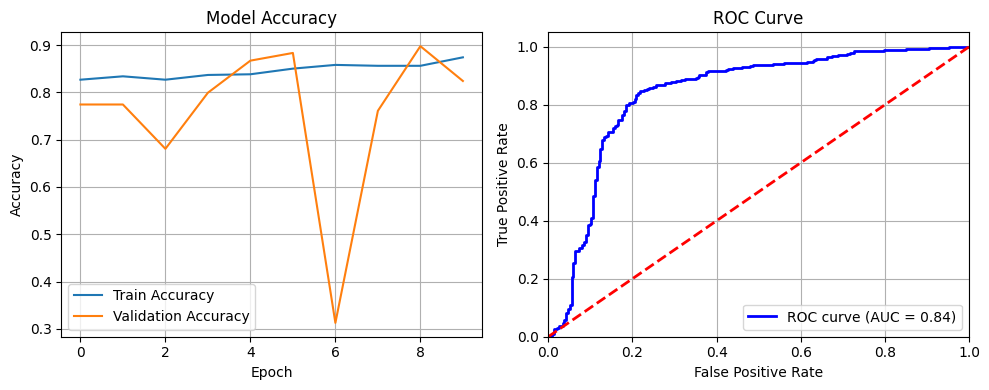

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming you have:
# model - your trained Keras model
# X_test, y_test - your test dataset
# If using tf.data.Dataset, convert to numpy arrays:
X_test = np.concatenate([x for x, y in test_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend(loc="lower right")
axs[1].grid(True)

plt.tight_layout()
plt.show()
